In [3]:
import sys, os
import numpy as np
import time, h5py
codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import default_paths
from utils import numpy_utils as numpy_utils
from model_fitting import initialize_fitting 
from sklearn import decomposition
import scipy.stats
import argparse


In [4]:
subject=1;
n_ori=4;
n_sf=4;
max_pc_to_retain=100;
debug=True; 
zscore_first=False

In [5]:
path_to_load = default_paths.pyramid_texture_feat_path

features_file = os.path.join(path_to_load, 'S%d_features_each_prf_%dori_%dsf.h5py'%(subject, n_ori, n_sf))
if not os.path.exists(features_file):
    raise RuntimeError('Looking at %s for precomputed features, not found.'%features_file)   
path_to_save = os.path.join(path_to_load, 'PCA')
if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    

prf_batch_size = 50 # batching prfs for loading, because it is a bit faster
n_prfs = models.shape[0]
n_prf_batches = int(np.ceil(n_prfs/prf_batch_size))          
prf_batch_inds = [np.arange(prf_batch_size*bb, np.min([prf_batch_size*(bb+1), n_prfs])) for bb in range(n_prf_batches)]

# going to treat lower-level and higher-level separately here, doing pca within each set.
# these values are just hard-coded based on how the features were generated, in texture_statistics_pyramid.py
n_ll_feats = 49 
n_hl_feats = 592

prf_inds_loaded = []
scores_ll_each_prf = []
wts_ll_each_prf = []
ev_ll_each_prf = []
scores_hl_each_prf = []
wts_hl_each_prf = []
ev_hl_each_prf = []

most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [6]:
prf_model_index = 0
print('Processing pRF %d of %d'%(prf_model_index, n_prfs))
if prf_model_index not in prf_inds_loaded:

    batch_to_use = np.where([prf_model_index in prf_batch_inds[bb] for \
                             bb in range(len(prf_batch_inds))])[0][0]
    assert(prf_model_index in prf_batch_inds[batch_to_use])

    print('Loading pre-computed features for prf models [%d - %d] from %s'%(prf_batch_inds[batch_to_use][0], \
                                                                      prf_batch_inds[batch_to_use][-1], features_file))
    features_each_prf_batch = None

    t = time.time()
    with h5py.File(features_file, 'r') as data_set:
        values = np.copy(data_set['/features'][:,:,prf_batch_inds[batch_to_use]])
        data_set.close() 
    elapsed = time.time() - t
    print('Took %.5f seconds to load file'%elapsed)

    prf_inds_loaded = prf_batch_inds[batch_to_use]
    features_each_prf_batch = values.astype(np.float32)
    values=None


Processing pRF 0 of 875
Loading pre-computed features for prf models [0 - 49] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf.h5py
Took 84.25242 seconds to load file


In [10]:
prf_inds_loaded

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [7]:
index_into_batch = np.where(prf_model_index==prf_inds_loaded)[0][0]
print('Index into batch for prf %d: %d'%(prf_model_index, index_into_batch))
features_in_prf = features_each_prf_batch[:,:,index_into_batch]
values=None
print('Size of features array for this image set and prf is:')
print(features_in_prf.shape)

features_ll = features_in_prf[:,0:n_ll_feats]
#         features_ll = features_ll[:,6:] # Taking out the pixel features for now 
features_hl = features_in_prf[:,n_ll_feats:]
assert(n_hl_feats==features_hl.shape[1])

Index into batch for prf 0: 0
Size of features array for this image set and prf is:
(10000, 641)


In [31]:
from feature_extraction import texture_statistics_pyramid

# Set up the pyramid
feature_types_exclude = []
n_prf_sd_out = 2
do_varpart=False # this doesn't do anything here
group_all_hl_feats = False # this doesn't do anything here
batch_size=100
device = 'cpu:0'
compute_features = True
_fmaps_fn = texture_statistics_pyramid.steerable_pyramid_extractor(pyr_height = n_sf, n_ori = n_ori)
_feature_extractor = texture_statistics_pyramid.texture_feature_extractor(_fmaps_fn,sample_batch_size=batch_size, \
                                                                         feature_types_exclude=feature_types_exclude, \
                                               n_prf_sd_out=n_prf_sd_out, aperture=aperture, do_varpart = do_varpart, \
                              compute_features=compute_features, group_all_hl_feats = group_all_hl_feats, device=device)

Feature types to exclude from the model:
[]


In [181]:
zgroup_labels = np.concatenate([np.zeros(shape=(1,150)), np.ones(shape=(1,1))], axis=1)


In [182]:
zgroup_labels 

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1.]])

In [40]:
dims = np.array(_feature_extractor.feature_type_dims_all)
is_ll = _feature_extractor.feature_is_ll
feature_type_dims_ll = dims[is_ll]
feature_type_dims_hl = dims[~is_ll]
n_ll_feats = np.sum(feature_type_dims_ll)
n_hl_feats = np.sum(feature_type_dims_hl)


In [159]:
# Groups to zscore within.
# Treating every pixel statistic as a different group because of different scales.
# Keeping the groups of mean magnitude features together across orients and scales - rather
# than z-scoring each column, to preserve informative difference across these channels.
zgroup_sizes_ll = [1,1,1,1,1,1] + list(feature_type_dims_ll[1:])
zgroup_sizes_hl = list(feature_type_dims_hl)
zgroup_labels_ll = np.concatenate([np.ones(shape=(1, zgroup_sizes_ll[ff]))*ff \
                                       for ff in range(len(zgroup_sizes_ll))], axis=1)
# For the marginal stats of lowpass recons, separating skew/kurtosis here
zgroup_labels_ll[zgroup_labels_ll==9] = 10
zgroup_labels_ll[0,np.where(zgroup_labels_ll==8)[1][np.arange(1,10,2)]] = 9

# for higher level groups, just retaining original grouping scheme 
zgroup_labels_hl = np.concatenate([np.ones(shape=(1, zgroup_sizes_hl[ff]))*ff \
                                       for ff in range(len(zgroup_sizes_hl))], axis=1)

In [166]:
def zscore_in_groups(data, group_labels):
    """
    Apply z-scoring to data of several columns at a time - column groupings given by group_labels.
    """
    if len(group_labels.shape)>1:
        group_labels = np.squeeze(group_labels)
    assert(len(group_labels.shape)==1)
    zdata = np.zeros(shape=np.shape(data))
    ungroups = np.unique(group_labels)
    for gg in range(len(ungroups)):       
        d = data[:,group_labels==ungroups[gg]]        
        zd = np.reshape(scipy.stats.zscore(d.ravel()), np.shape(d))        
        zdata[:,group_labels==ungroups[gg]] = zd
        
    return zdata

Text(0.5, 1.0, 'STD (after z-scoring groups)')

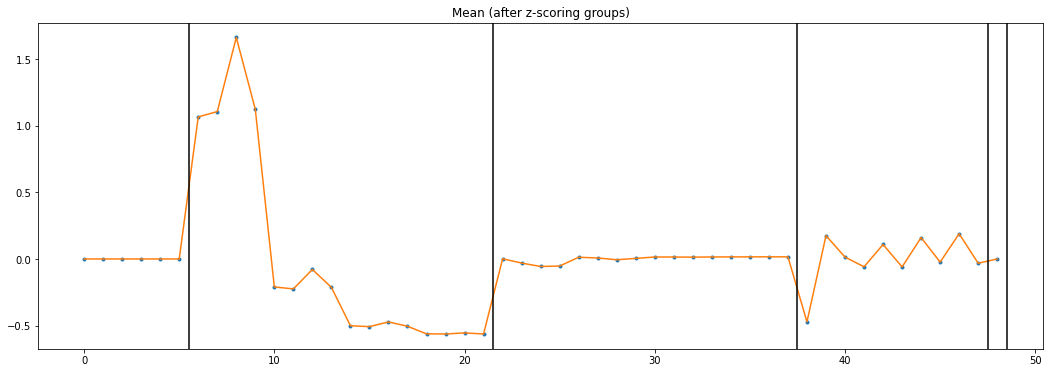

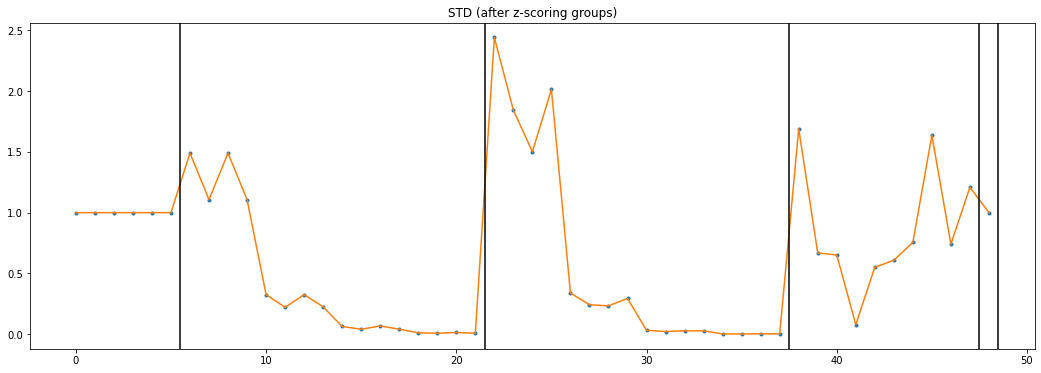

In [170]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6));
plt.plot(np.mean(features_ll_z, axis=0), '.')
plt.plot(np.mean(features_ll_z, axis=0))
for ff in range(len(feature_type_dims_ll)):
    plt.axvline(np.sum(feature_type_dims_ll[0:ff+1])-0.5, color='k')
plt.title('Mean (after z-scoring groups)')
plt.figure(figsize=(18,6));
plt.plot(np.std(features_ll_z, axis=0), '.')
plt.plot(np.std(features_ll_z, axis=0))
for ff in range(len(feature_type_dims_ll)):
    plt.axvline(np.sum(feature_type_dims_ll[0:ff+1])-0.5, color='k')
plt.title('STD (after z-scoring groups)')
 

Text(0.5, 1.0, 'STD (after z-scoring groups)')

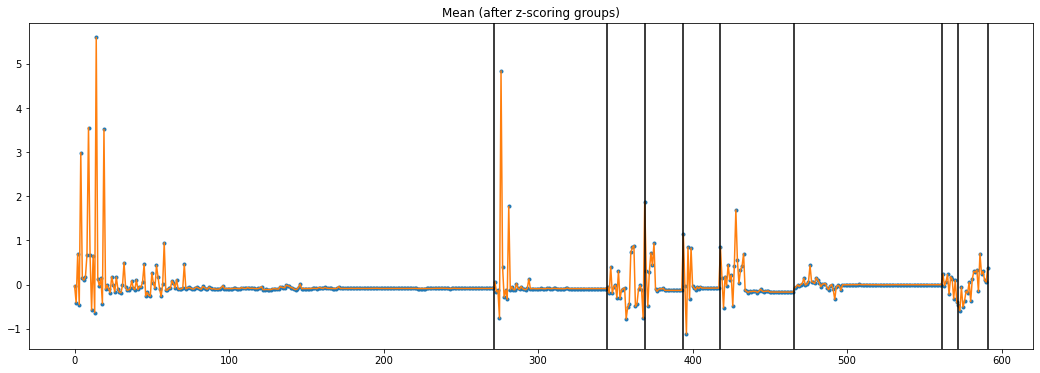

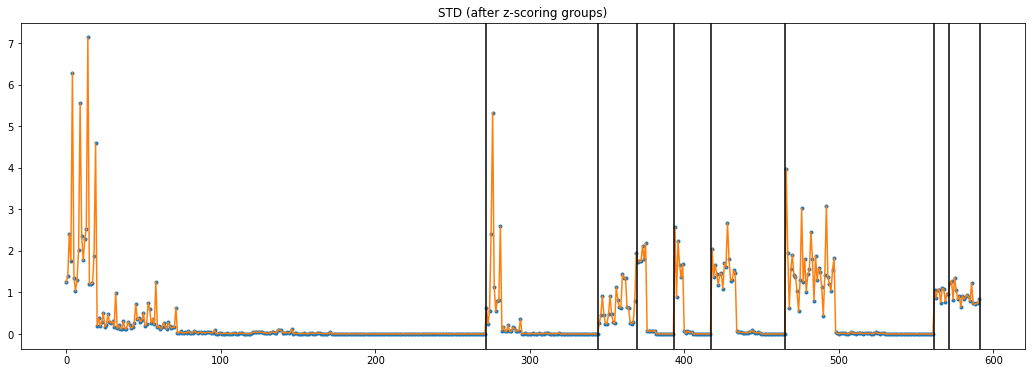

In [171]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6));
plt.plot(np.mean(features_hl_z, axis=0), '.')
plt.plot(np.mean(features_hl_z, axis=0))
for ff in range(len(feature_type_dims_hl)):
    plt.axvline(np.sum(feature_type_dims_hl[0:ff+1])-0.5, color='k')
plt.title('Mean (after z-scoring groups)')

plt.figure(figsize=(18,6));
plt.plot(np.std(features_hl_z, axis=0), '.')
plt.plot(np.std(features_hl_z, axis=0))
for ff in range(len(feature_type_dims_hl)):
    plt.axvline(np.sum(feature_type_dims_hl[0:ff+1])-0.5, color='k')
plt.title('STD (after z-scoring groups)')
 
 

In [157]:
np.std(features_ll_z[:,[38,40,42,44,46]])

0.9999999575832026

In [158]:
np.std(features_ll_z[:,[39,41,43,45,47]])

1.0000000326938574

Text(0.5, 1.0, 'STD (raw)')

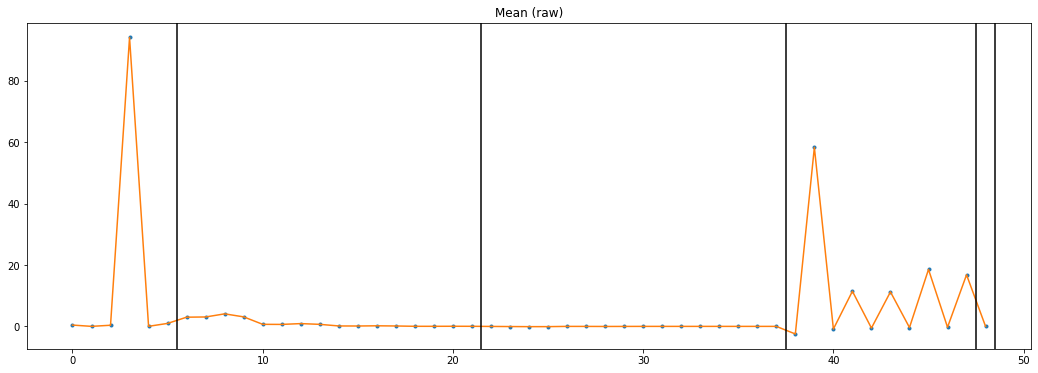

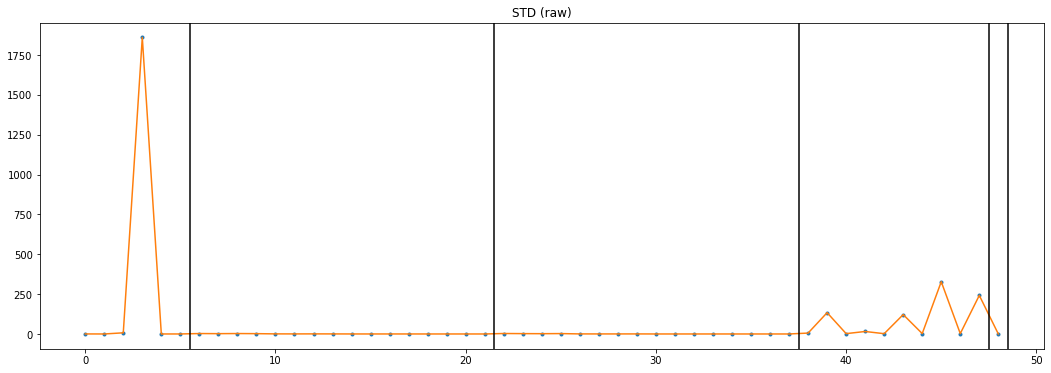

In [172]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6));
plt.plot(np.mean(features_ll, axis=0), '.')
plt.plot(np.mean(features_ll, axis=0))
for ff in range(len(feature_type_dims_ll)):
    plt.axvline(np.sum(feature_type_dims_ll[0:ff+1])-0.5, color='k')
plt.title('Mean (raw)')

plt.figure(figsize=(18,6));
plt.plot(np.std(features_ll, axis=0), '.')
plt.plot(np.std(features_ll, axis=0))
for ff in range(len(feature_type_dims_ll)):
    plt.axvline(np.sum(feature_type_dims_ll[0:ff+1])-0.5, color='k')
plt.title('STD (raw)')
  
 

Text(0.5, 1.0, 'STD (raw)')

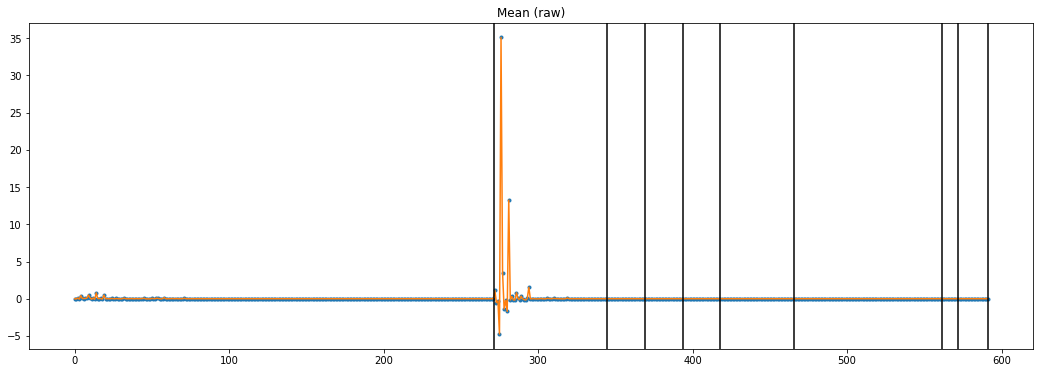

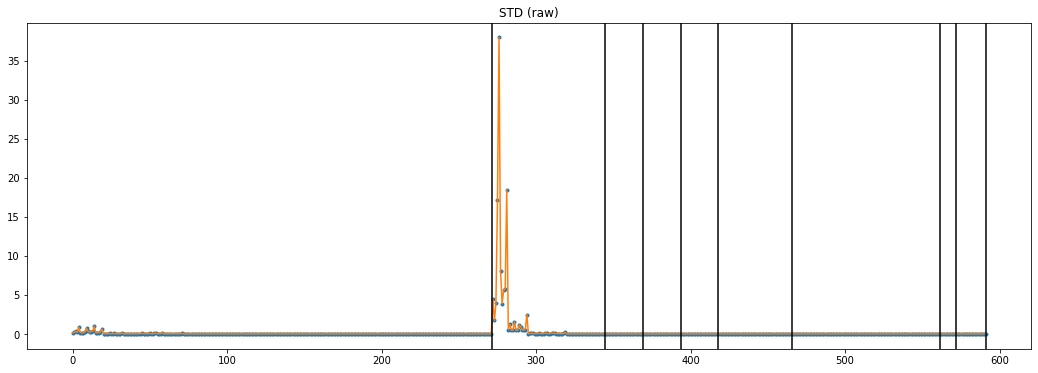

In [173]:
   
plt.figure(figsize=(18,6));
plt.plot(np.mean(features_hl, axis=0), '.')
plt.plot(np.mean(features_hl, axis=0))
for ff in range(len(feature_type_dims_hl)):
    plt.axvline(np.sum(feature_type_dims_hl[0:ff+1])-0.5, color='k')
plt.title('Mean (raw)')

plt.figure(figsize=(18,6));
plt.plot(np.std(features_hl, axis=0), '.')
plt.plot(np.std(features_hl, axis=0))
for ff in range(len(feature_type_dims_hl)):
    plt.axvline(np.sum(feature_type_dims_hl[0:ff+1])-0.5, color='k')
plt.title('STD (raw)')


In [175]:
features_ll_z = zscore_in_groups(features_ll, zgroup_labels_ll)
features_hl_z = zscore_in_groups(features_hl, zgroup_labels_hl)

In [177]:
# scores_ll, wts_ll, ev_ll = do_pca(features_ll, max_pc_to_retain, zscore_first=zscore_first)
scores_ll, wts_ll, ev_ll = do_pca(features_ll_z, max_pc_to_retain, zscore_first=zscore_first)
scores_ll_each_prf.append(scores_ll)
wts_ll_each_prf.append(wts_ll)
ev_ll_each_prf.append(ev_ll)

# scores_hl, wts_hl, ev_hl = do_pca(features_hl, max_pc_to_retain, zscore_first=zscore_first)
scores_hl, wts_hl, ev_hl = do_pca(features_hl_z, max_pc_to_retain, zscore_first=zscore_first)
scores_hl_each_prf.append(scores_hl)
wts_hl_each_prf.append(wts_hl)
ev_hl_each_prf.append(ev_hl)
        

Running PCA: original size of array is [10000 x 49]
Time elapsed: 0.05253
First element of ev: 29.12
Requires 16 components to explain 95 pct var
Running PCA: original size of array is [10000 x 592]
Time elapsed: 1.20941
First element of ev: 23.79
Requires 46 components to explain 95 pct var


In [174]:

    
def do_pca(values, max_pc_to_retain=None, zscore_first=False):
    
    n_features_actual = values.shape[1]
    n_trials = values.shape[0]
    
    if max_pc_to_retain is not None:        
        n_comp = np.min([np.min([max_pc_to_retain, n_features_actual]), n_trials])
    else:
        n_comp = np.min([n_features_actual, n_trials])
        
    if zscore_first:
        # zscore each column (optional)
        vals_m = np.mean(values, axis=0, keepdims=True) 
        vals_s = np.std(values, axis=0, keepdims=True)         
        values -= vals_m
        values /= vals_s 
        
    print('Running PCA: original size of array is [%d x %d]'%(n_trials, n_features_actual))
    t = time.time()
    pca = decomposition.PCA(n_components = n_comp, copy=False)
    scores = pca.fit_transform(values)           
    elapsed = time.time() - t
    print('Time elapsed: %.5f'%elapsed)
    values = None            
    wts = pca.components_
    ev = pca.explained_variance_
#     print(ev)
#     print(np.sum(ev))
    ev = ev/np.sum(ev)*100
    
    print('First element of ev: %.2f'%ev[0])
    # print this out as a check...if it is always 1, this can mean something is wrong w data.
    if np.size(np.where(np.cumsum(ev)>=95))>0:
        n_comp_needed = np.where(np.cumsum(ev)>=95)[0][0]
        print('Requires %d components to explain 95 pct var'%n_comp_needed)    
    else:
        n_comp_needed = n_comp
        print('Requires more than %d components to explain 95 pct var'%n_comp_needed)
    
    return scores, wts, ev

